<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/09.%20Word%20Embedding/09_05_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  09-05 GloVe 훈련시키기


출처: https://wikidocs.net/22885

###  실습을 위해 프롬프트에서 아래 커맨드로 GloVe 패키지를 설치합니다.



In [ ]:
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


글로브(Global Vectors for Word Representation, GloVe)는 카운트 기반과 예측 기반을 모두 사용하는 방법론으로 2014년에 미국 스탠포드대학에서 개발한 단어 임베딩 방법론입니다. 

앞서 학습하였던 기존의 카운트 기반의 LSA(Latent Semantic Analysis)와 예측 기반의 Word2Vec의 단점을 지적하며 이를 보완한다는 목적

 현재까지의 연구에 따르면 단정적으로 Word2Vec와 GloVe 중에서 어떤 것이 더 뛰어나다고 말할 수는 없고, 이 두 가지 전부를 사용해보고 성능이 더 좋은 것을 사용하는 것이 바람직합니다.

 ## 1. 기존 방법론에 대한 비판

LSA:  DTM이나 TF-IDF 행렬과 같이 각 문서에서의 각 단어의 빈도수를 카운트 한 행렬이라는 전체적인 통계 정보를 입력으로 받아 차원을 축소(Truncated SVD)하여 잠재된 의미를 끌어내는 방법론

-

Word2Vec: 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반의 방법론

-

LSA는 카운트 기반으로 코퍼스의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:? (정답은 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어집니다. Word2Vec는 예측 기반으로 단어 간 유추 작업에는 LSA보다 뛰어나지만, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 코퍼스의 전체적인 통계 정보를 반영하지 못합니다. GloVe는 이러한 기존 방법론들의 각각의 한계를 지적하며, LSA의 메커니즘이었던 카운트 기반의 방법과 Word2Vec의 메커니즘이었던 예측 기반의 방법론 두 가지를 모두 사용

--
--

## 2. 윈도우 기반 동시 등장 행렬(Window based Co-occurrence Matrix)

윈도우 크기가 N일 때는 좌, 우에 존재하는 N개의 단어만 참고하게 됩니다. 윈도우 크기가 1일 때, 위의 텍스트를 가지고 구성한 동시 등장 행렬은 다음과 같습니다.

I like deep learning
I like NLP
I enjoy flying


위의 테이블은 스탠포드 대학교의 자연어 처리 강의를 참고하였습니다.
링크 : http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture02-wordvecs2.pdf




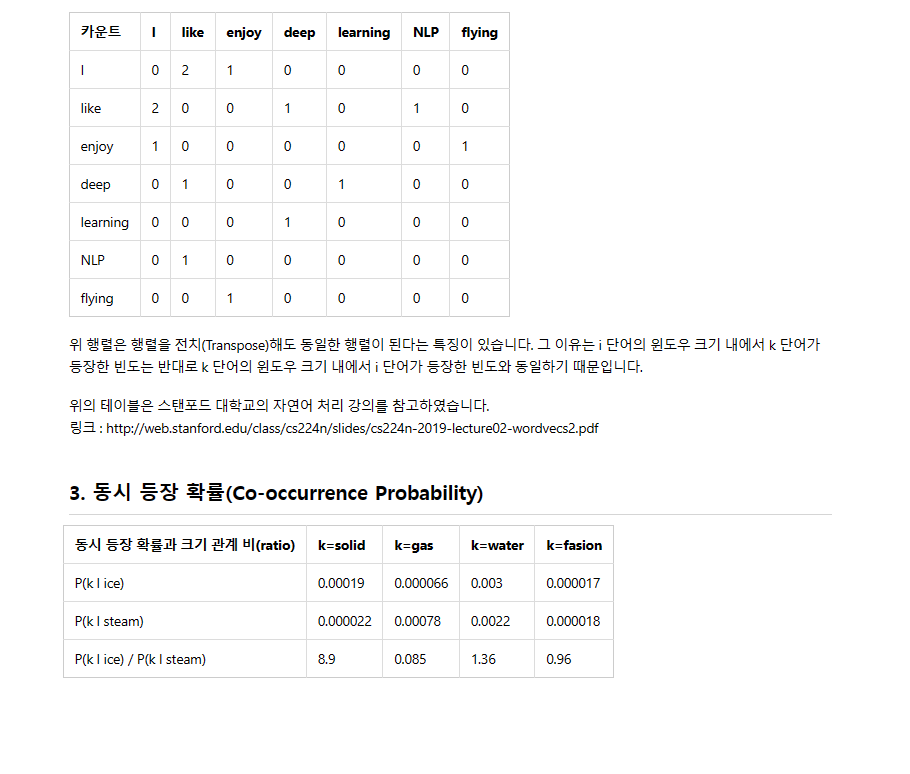

In [ ]:
Image("/content/drive/MyDrive/Colab Notebooks/09-05 glove1.png")

위 행렬은 행렬을 전치(Transpose)해도 동일한 행렬이 된다는 특징이 있습니다. 그 이유는 i 단어의 윈도우 크기 내에서 k 단어가 등장한 빈도는 반대로 k 단어의 윈도우 크기 내에서 i 단어가 등장한 빈도와 동일하기 때문입니다.

# 3. 동시 등장 확률(Co-occurrence Probability)

동시 등장 행렬에 대해서 이해했으니, 동시 등장 확률에 대해서 이해해봅시다. 아래의 표는 어떤 동시 등장 행렬을 가지고 정리한 동시 등장 확률(Co-occurrence Probability)을 보여줍니다. 그렇다면, 동시 등장 확률이란 무엇일까요?

동시 등장 확률 
는 동시 등장 행렬로부터 특정 단어 i의 전체 등장 횟수를 카운트하고, 특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률입니다.



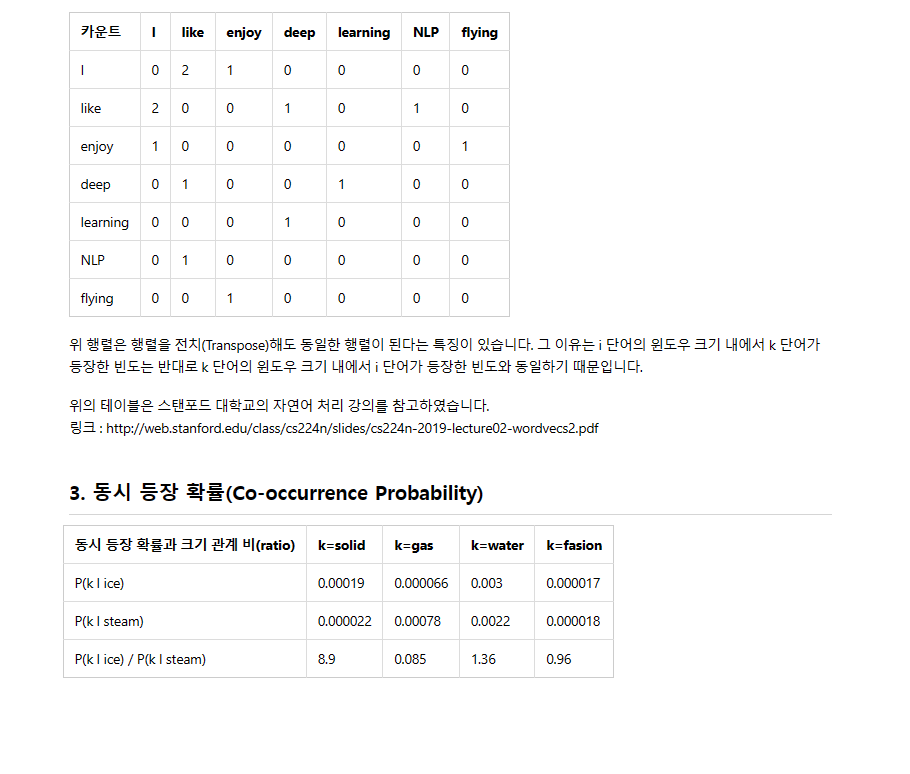

In [ ]:
Image("/content/drive/MyDrive/Colab Notebooks/09-05 glove1.png")

위의 표를 통해 알 수 있는 사실은 ice가 등장했을 때 solid가 등장할 확률 0.00019은 steam이 등장했을 때 solid가 등장할 확률인 0.000022보다 약 8.9배 크다는 겁니다. 그도 그럴 것이 solid는 '단단한'이라는 의미를 가졌으니까 '증기'라는 의미를 가지는 steam보다는 당연히 '얼음'이라는 의미를 가지는 ice라는 단어와 더 자주 등장할 겁니다.

수식적으로 다시 정리하여 언급하면 k가 solid일 때, P(solid l ice) / P(solid l steam)를 계산한 값은 8.9가 나옵니다. 이 값은 1보다는 매우 큰 값입니다. 왜냐면 P(solid | ice)의 값은 크고, P(solid | steam)의 값은 작기 때문입니다.

그런데 k를 solid가 아니라 gas로 바꾸면 얘기는 완전히 달라집니다. gas는 ice보다는 steam과 더 자주 등장하므로, P(gas l ice) / P(gas l steam)를 계산한 값은 1보다 훨씬 작은 값인 0.085가 나옵니다. 반면, k가 water인 경우에는 solid와 steam 두 단어 모두와 동시 등장하는 경우가 많으므로 1에 가까운 값이 나오고, k가 fasion인 경우에는 solid와 steam 두 단어 모두와 동시 등장하는 경우가 적으므로 1에 가까운 값이 나옵니다. 보기 쉽도록 조금 단순화해서 표현한 표는 다음과 같습니다.

4. 손실 함수(Loss function)

https://wikidocs.net/22885 수식 참고 

In [ ]:
pip install glove_python_binary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.9/974.9 KB 43.8 MB/s eta 0:00:00


GloVe의 입력이 되는 훈련 데이터는 '영어와 한국어 Word2Vec 학습하기' 챕터에서 사용한 영어 데이터를 재사용합니다. 모든 동일한 전처리를 마치고 이전과 동일하게 result에 결과가 저장되어있다고 가정합니다.

In [ ]:
pip install glove_python_binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f5436edfdc0>)

In [ ]:
import gensim
gensim.__version__

'3.6.0'

In [ ]:
nltk.__version__

'3.8.1'

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python --version

Python 3.8.10


In [ ]:
 pip install -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

# https://github.com/nltk/nltk/issues/2927  문제가 동일하게 발생
# 3일 고생, punkt파일을 직접 다운받아서 압축풀고 곳곳에 복붙하고, nltk 3.8.1 version 설치하니 진행됨.
# 참고로 구글 코랩도 3.7 버젼 - 하니 3초만에 실행됨. 
# Anaconda prompt에서 했던 명령어 pip install -U nltk

In [ ]:
print('총 샘플의 개수 : {}'.format(len(result)))


총 샘플의 개수 : 273424


In [ ]:

from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
     
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#gensim
# https://bobbyhadz.com/blog/python-error-legacy-install-failure

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
print(glove.most_similar("man"))


[('woman', 0.9600224776382482), ('guy', 0.8911272532869156), ('girl', 0.8631625505574315), ('young', 0.8437352286578839)]


In [ ]:
print(glove.most_similar("boy"))


[('girl', 0.9311509807938655), ('woman', 0.8360406610591835), ('man', 0.8183021292801563), ('kid', 0.8124508948172507)]


In [ ]:
print(glove.most_similar("university"))


[('harvard', 0.8780095832956238), ('mit', 0.8492763834164258), ('cambridge', 0.8477481690881447), ('stanford', 0.8446275445233876)]


In [ ]:
print(glove.most_similar("water"))


[('air', 0.8449252166086476), ('clean', 0.8355789633336753), ('fresh', 0.8351531485461554), ('food', 0.8279727905275411)]


In [ ]:
print(glove.most_similar("physics"))


[('chemistry', 0.871043052888849), ('beauty', 0.8604738473664919), ('economics', 0.85822252076994), ('mathematics', 0.8541170634464175)]


In [ ]:
print(glove.most_similar("muscle"))


[('tissue', 0.8415927625165398), ('nerve', 0.834853817903756), ('skeletal', 0.7729425398142652), ('channel', 0.7556863175946017)]


In [ ]:
print(glove.most_similar("clean"))


[('fresh', 0.846484784848791), ('water', 0.8355789633336753), ('heat', 0.7893668702451856), ('wind', 0.7847794730420583)]
